In [1]:
import numpy as np
import matplotlib.pyplot as plt 

# Simulating A Magnet Using A Monte Carlo Algorithm

We begin with an array of magnetic moments $\{ \vec{m}_1, \vec{m}_2, \dots, \vec{m}_n \} $ that has been produced at random.Each moment's length is fixed at $ |\vec{m}_i| = 1 $, but the orientation is chosen randomly. We can construct this by generating a random polar angle $ \varphi_i $ and azimuthal angle $\theta_i$ and using spherical coordinates:
$$ \vec{m}_i = \begin{pmatrix} \cos\varphi_i\sin\theta_i \\ \sin\varphi_i\sin\theta_i \\ \cos\theta_i \end{pmatrix} $$

## Starting configurations

### Magnetic moments

In [2]:
length= 20#each row or column
numberOfMoments=length**2 # this represents a quadratic grid of moments

phi= 2*np.pi * np.random.rand(numberOfMoments).reshape(length,length,1)
#random angle of phi, between 0:2pi
theta= np.pi * np.random.rand(numberOfMoments).reshape(length,length,1) 
#random angle of 

In [3]:
magnet=np.array([
    np.cos(phi)*np.sin(theta),np.sin(phi)*np.sin(theta),np.cos(theta)
])

### positions

In [4]:
x,y,z=np.meshgrid(np.arange(length),np.arange(length),np.arange(1))

### Plotting

* defining some plotting functions that we are gonna use often

In [5]:
def plotMagnet(magnet):
    plt.rcParams['figure.figsize'] =[35,20]
    arrowplot = plt.axes(projection='3d')
    arrowplot.set_zlim(-1,1)
    arrowplot.set_box_aspect(aspect=(length,length,2))
    arrowplot.axis(False) #remove axis to see the image more clearly
    arrowplot.quiver(
    x,y,z,
    magnet[0], magnet[1],magnet[2]
    )
    #plotting the points.
    arrowplot.scatter3D(x,y,z,color='red')
    
def plotEnergy(steps,currentEnergyList):
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    plt.plot(range(steps+1), currentEnergyList)
    plt.xlabel('number of steps')
    plt.ylabel('energy')

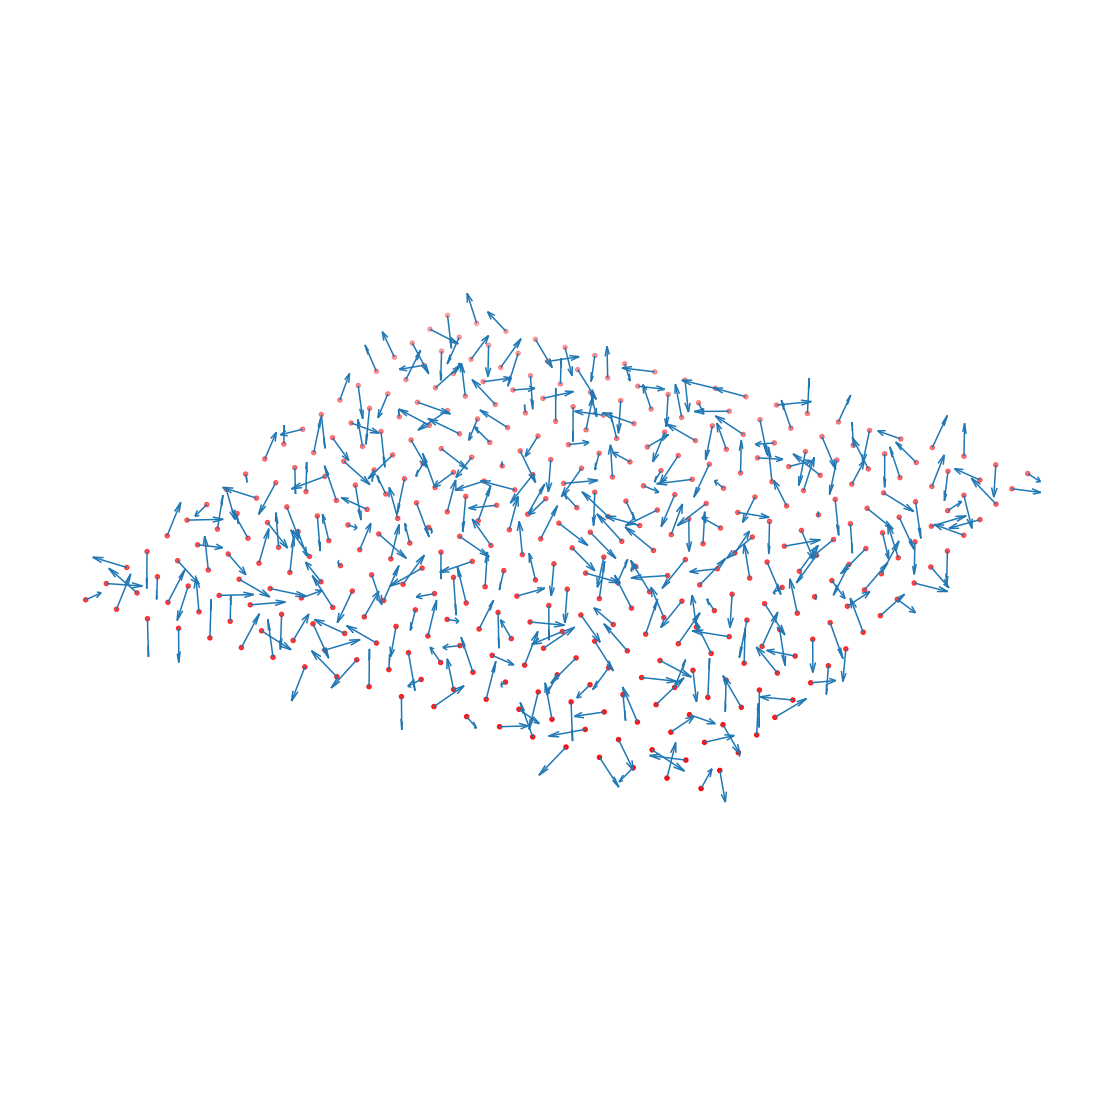

In [6]:
plotMagnet(magnet)

## 1.First verision

### Defining the energy

We are searching for the configuration with the lowest energy. For a ferromagnet the energy can be written as:

$$ H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j  $$

Of course, this is a simplified formula, but we will use it, for now, to test our logic as we know that every moment is interacting with its direct neighbor ($ <i,j>$) and prefers a parallel orientation as long as $(J > 0) $

In [7]:
J=1
def contribution(J,magnet,x,y):
    #assume the magnet is wrapped, so the last magnetic moment is connected to the first one; to ease calculations.
    right=magnet[:,(x+1)%length,y,0]
    left=magnet[:,(x-1)%length,y,0]
    up=magnet[:,x,(y+1)%length,0]
    down=magnet[:,x,(y-1)%length,0]
    return (-1/2)*J*np.dot(magnet[:,x,y,0],right+left+up+down)
def energy(J,magnet):
    return sum(sum(contribution(J,magnet,x,y) for y in range(length)) for x in range(length))

### Metropolis step

To run the Monte Carlo algorithm. We will repeatedly do the so-called Metropolis steps: 

1. A random magnetic moment is selected.
2. It is reoriented along a random direction.
3. The energy is calculated $ E_\mathrm{new} $.
4. The energy is compared to the old energy $ E_\mathrm{old}$: 
    - If the energy is decreased, the random change of the magnetic moment is accepted. 
    - If the energy is increased, the old magnetic moment is restored.

In [8]:
def metropolisStep(J,magnet):
    # first step.
    x = np.random.randint(length)
    y = np.random.randint(length)
    oldEnergy = 2 * contribution(J,magnet,x,y)
     # *2 here is because we need to consider not only how this magnetic moment affects its neighbours, but also how 
    # its neighbors will affect it after this change.
    storedmagnet = magnet[:,x,y,0].copy()
    # 2nd step.
    newPhi = 2*np.pi * np.random.rand()
    newTheta = np.pi * np.random.rand()
    magnet[:,x,y,0] = np.array([ np.cos(newPhi)*np.sin(newTheta), np.sin(newPhi)*np.sin(newTheta), np.cos(newTheta) ])
    # 3rd step. 
    newEnergy = 2 * contribution(J,magnet,x,y)   
    # 4th step.
    if ( newEnergy < oldEnergy):
        energyChange = newEnergy - oldEnergy
    else:
        magnet[:,x,y,0] = storedmagnet
        energyChange = 0
    return [magnet, energyChange]

### Running the monte carlo algorithm

In [9]:
steps=1000000
magnet1=magnet.copy() #copying to try different implementations.

currentEnergy=energy(J,magnet1)
currentEnergyList=[currentEnergy]#tracking the energy for plotting

for i in range(steps):
    magnet1,energyChange = metropolisStep(J,magnet1)
    
    #for plotting purposes
    currentEnergy=currentEnergy+energyChange
    currentEnergyList.append(currentEnergy)
    

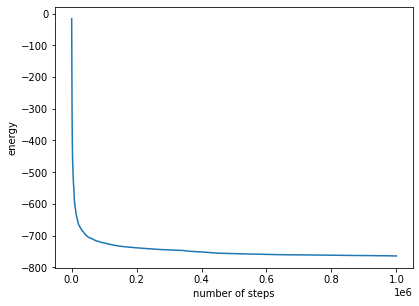

In [10]:
plotEnergy(steps,currentEnergyList)

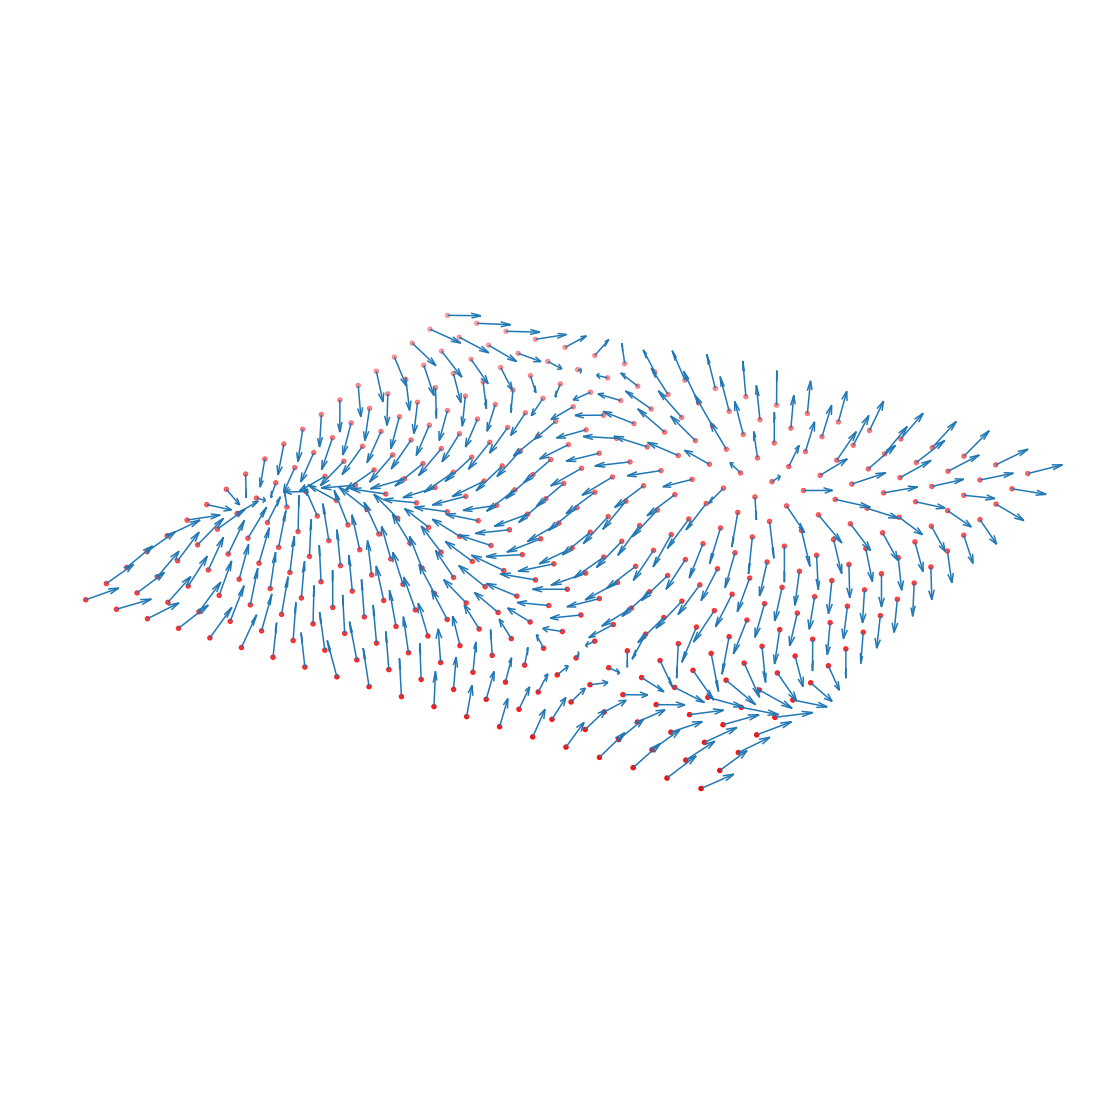

In [11]:
plotMagnet(magnet1)

In [12]:
currentEnergyList[-1]
# we know that the answer should be -800, however, we needed 1000000 
# to come with this approximation -which isn't good- 
# not to say that there's always the problem that we get stuck at a local minimum position,
# another reason for such a result is that our energy definition is a bit simplified. 
# So next, we will change our implementation of the metropolis step a bit for optimization,
# and afterward, change our energy definition to a more rigorous one.


-763.8791689320248

## 2. Update 1: re-implementing the metropolis step with finite temperatures.

The problem with our previous implementation is that we always ignore any change that causes an increase in energy, so we probably will get stuck at a minimum local position (sometimes you have to allow some increase in local energy; to reach an even lower energy state for the whole system.

__Update 1:__ For finite temperatures $ T $, we accept the change with a chance $ e^{\left(-\frac{E_\mathrm{new}-E_\mathrm{old}}{k_BT}\right)} $

In [13]:
def metropolisStepTemp(J,magnet,KbT):
    # first step.
    x = np.random.randint(length)
    y = np.random.randint(length)
    oldEnergy = 2 * contribution(J,magnet,x,y)
     # *2 here is because we need to consider not only how this magnetic moment affects its neighbours, but also how 
    # its neighbors will affect it after this change.
    storedmagnet = magnet[:,x,y,0].copy()
    # 2nd step.
    newPhi = 2*np.pi * np.random.rand()
    newTheta = np.pi * np.random.rand()
    magnet[:,x,y,0] = np.array([ np.cos(newPhi)*np.sin(newTheta), np.sin(newPhi)*np.sin(newTheta), np.cos(newTheta) ])
    # 3rd step. 
    newEnergy = 2 * contribution(J,magnet,x,y)   
    # 4th step.
    if ( newEnergy < oldEnergy):
        energyChange = newEnergy - oldEnergy
    else:
        if np.random.rand() < np.exp(- (newEnergy-oldEnergy)/KbT):
            #accepting the change.
            energyChange = newEnergy - oldEnergy
        else:   
            magnet[:,x,y,0] = storedmagnet
            energyChange = 0
    return [magnet, energyChange]

In [14]:
steps=1000000 

magnet2=magnet.copy()
currentEnergy=energy(J,magnet2)
currentEnergyList=[currentEnergy]#tracking the energy for plotting

for i in range(steps):
    KbT=0.2* (1-i/steps) #dynamically changing temperature.
    magnet2,energyChange = metropolisStepTemp(J,magnet2,KbT) #considering finite temperatures 
    
    #for plotting purposes
    currentEnergy=currentEnergy+energyChange
    currentEnergyList.append(currentEnergy)

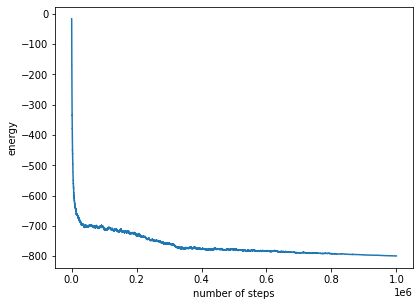

In [15]:
plotEnergy(steps,currentEnergyList)

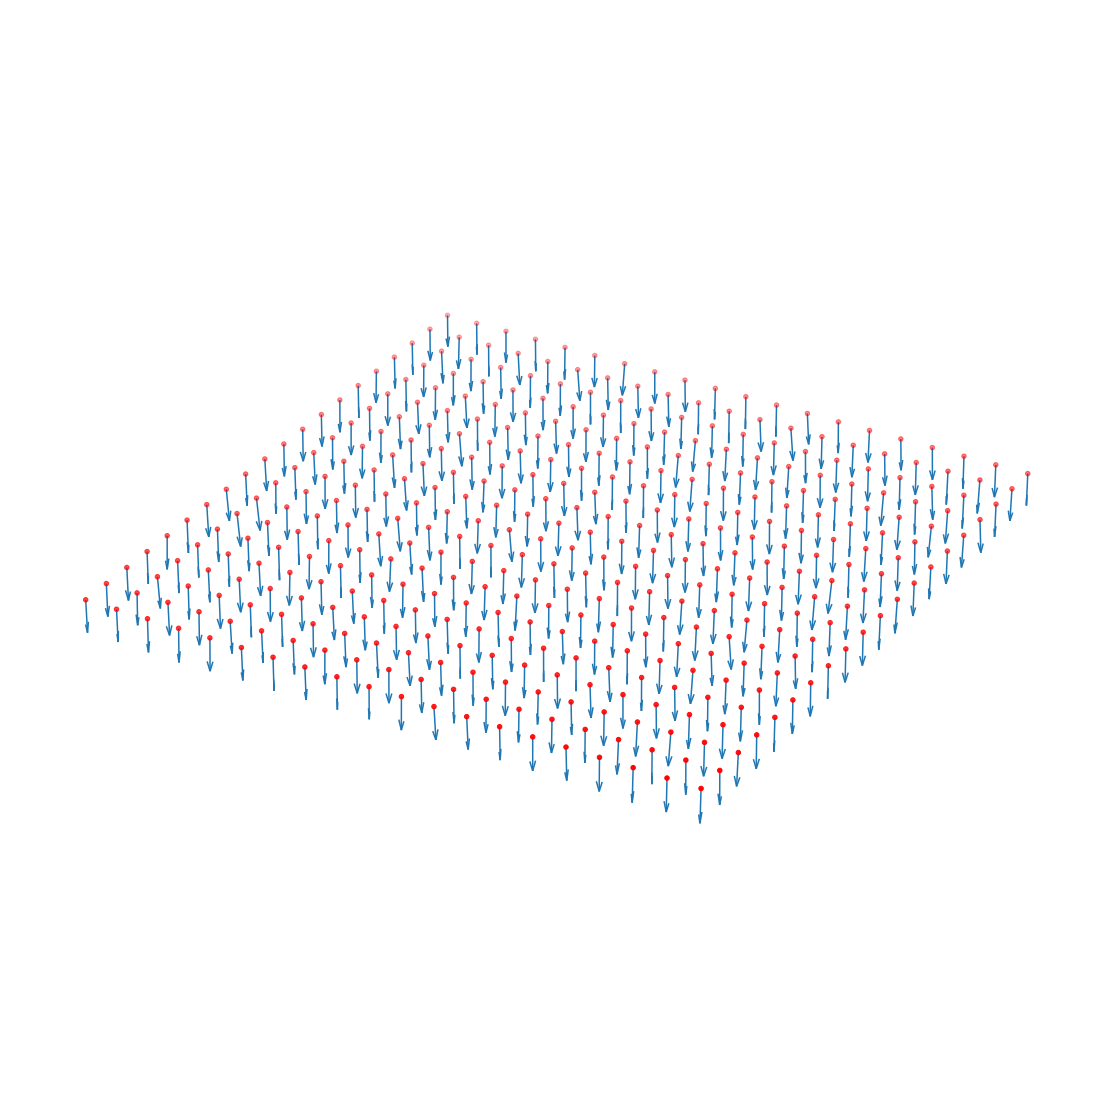

In [16]:
plotMagnet(magnet2)
#looks like a very good ferromagnet.

In [17]:
currentEnergyList[-1]
#Much better accuracy.

-799.267899900785

## 3. Update 2: Redefining the enenrgy

The problem with our previous energy definition is that it's not well defined, there's no preferable direction that ensures that the system is in its lowest energy state, as long as all the magnetic moments' point in the same direction, for example, in the above plot, there was no reason for the moments to point downward specifically, they could all point towards the x-direction, or towards the y-direction.

__Update 2:__ We can apply an external magnetic field $ \vec{B} $. This leads to the energy:

$$ H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j - \mu \sum_i \vec{B}\cdot \vec{m}_i $$

In [18]:
#we already defined the first part of the equation, all we have to do is to define the magnetic enrgy.
Mu=1
B=np.array([0,0,0.1]) #because B points to the +ve z-direction, so this will be the prefared direction.
def magneticContribution(Mu,B,magnet,x,y):
    return -Mu*np.dot(B,magnet[:,x,y,0])

def magneticEnergy(Mu,B,magnet):
    return sum(sum(magneticContribution(Mu,B,magnet,x,y) for y in range(length)) for x in range(length))

In [19]:
def metropolisStepMagnetic(Mu,B,J,magnet,KbT):
    # first step.
    x = np.random.randint(length)
    y = np.random.randint(length)
    oldEnergy = 2 * contribution(J,magnet,x,y) + magneticContribution(Mu,B,magnet,x,y)
     # *2 here is because we need to consider not only how this magnetic moment affects its neighbours, but also how 
     # its neighbors will affect it after this change (how i affects j and also how j affects i).
     # we don't need the *2 with the magneticContribution, because it only depends on (i) from the eqaution.
    storedmagnet = magnet[:,x,y,0].copy()
    # 2nd step.
    newPhi = 2*np.pi * np.random.rand()
    newTheta = np.pi * np.random.rand()
    magnet[:,x,y,0] = np.array([ np.cos(newPhi)*np.sin(newTheta), np.sin(newPhi)*np.sin(newTheta), np.cos(newTheta) ])
    # 3rd step. 
    newEnergy = 2 * contribution(J,magnet,x,y) + magneticContribution(Mu,B,magnet,x,y) 
    # 4th step.
    if ( newEnergy < oldEnergy):
        energyChange = newEnergy - oldEnergy
    else:
        if np.random.rand() < np.exp(- (newEnergy-oldEnergy)/KbT):
            #accepting the change.
            energyChange = newEnergy - oldEnergy
        else:   
            magnet[:,x,y,0] = storedmagnet
            energyChange = 0
    return [magnet, energyChange]

In [20]:
steps=1000000 

magnet3=magnet.copy()
currentEnergy=energy(J,magnet3)+magneticEnergy(Mu,B,magnet3)
currentEnergyList=[currentEnergy]#tracking the energy for plotting

for i in range(steps):
    KbT=0.2* (1-i/steps) #dynamically changing temperature.
    magnet3,energyChange = metropolisStepMagnetic(Mu,B,J,magnet3,KbT) #considering finite temperatures and magnetic field. 
    
    #for plotting purposes
    currentEnergy=currentEnergy+energyChange
    currentEnergyList.append(currentEnergy)

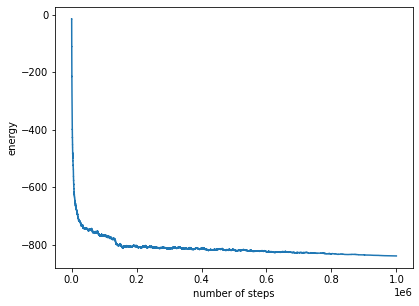

In [21]:
plotEnergy(steps,currentEnergyList)

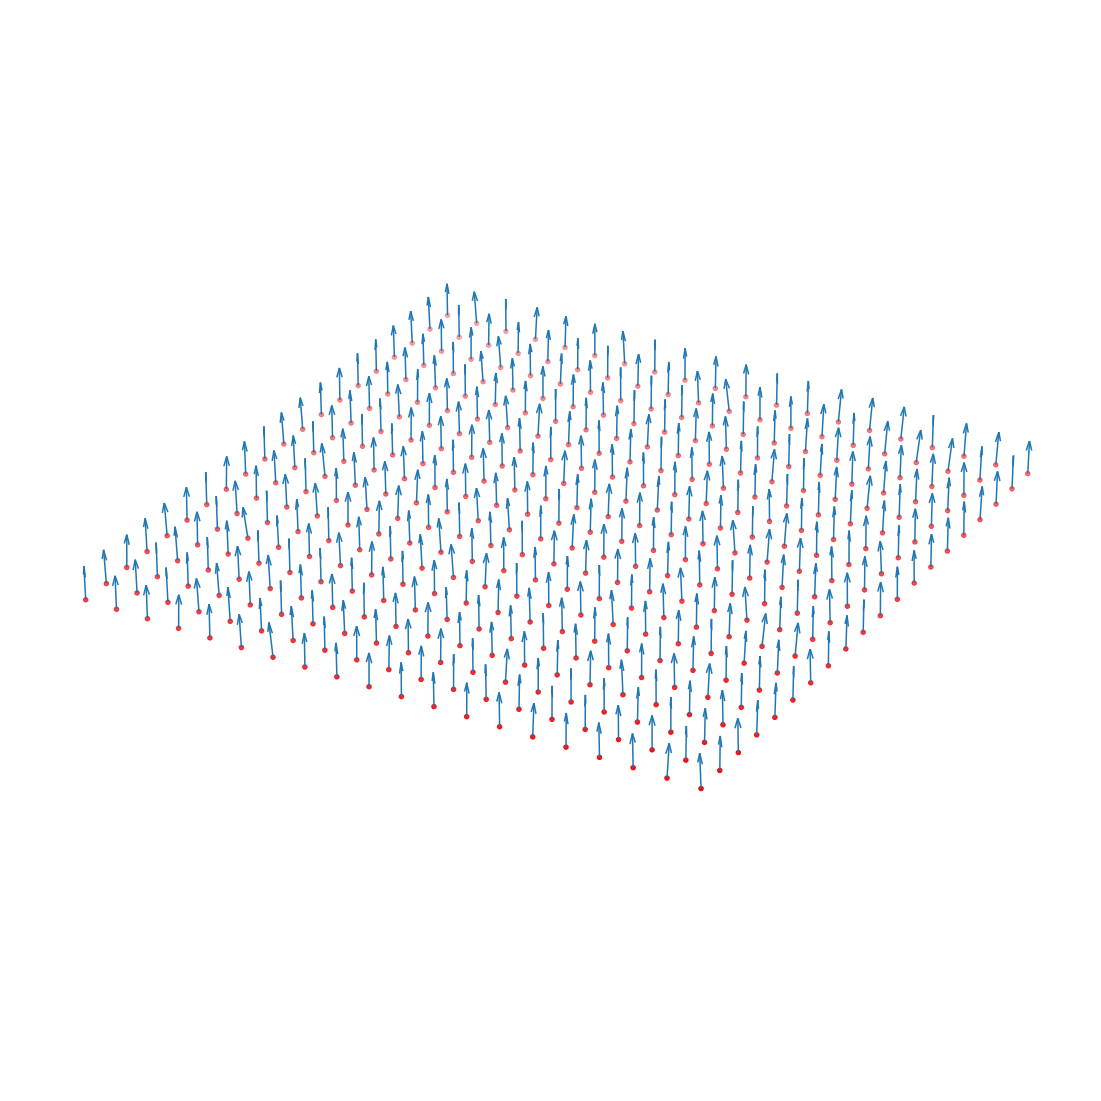

In [22]:
plotMagnet(magnet3)
#as you can see it aims toward the +ve z direction as it should do.

## 4. Update 3: including the Dzyaloshinskii–Moriya interaction (asymmetric exchange).

Our definition for the energy is still pretty much simple and not realistic enough, so we will redefine it again by introducing the Dzyaloshinskii–Moriya interaction which gives rise to non-collinear spin texture.

$$ H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j - \mu B \sum_i m_i^{(z)}  + \frac{1}{2}\sum_{<i,j>}\vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right)$$

The vectors $ \vec{D}_{ij} $ are determined by the broken inversion symmetry. In our example, they shall point along the direction $ i \rightarrow j $. 

As an example, let us consider a bond along the $ x $ direction:

$$ \vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right) = D \vec{e}_x \cdot \left(\vec{m}_i\times\vec{m}_j\right) = D \left( m_i^{(y)}m_j^{(z)} - m_i^{(z)}m_j^{(y)} \right)$$

For a bond along the $y$ direction:

$$ \vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right) = D \vec{e}_y \cdot \left(\vec{m}_i\times\vec{m}_j\right) = D \left( m_i^{(z)}m_j^{(x)} - m_i^{(x)}m_j^{(z)} \right)$$

In [35]:
#we will increase the sample for this one, to see the effect better
length=40
numberOfMoments=length**2
phi= 2*np.pi * np.random.rand(numberOfMoments).reshape(length,length,1)
theta= np.pi * np.random.rand(numberOfMoments).reshape(length,length,1) 
magnet4=np.array([
    np.cos(phi)*np.sin(theta),np.sin(phi)*np.sin(theta),np.cos(theta)])
x,y,z=np.meshgrid(np.arange(length),np.arange(length),np.arange(1))

In [36]:
D=0.25 #much smaller than J
def DmiContribution(D,magnet,x,y):
    #assume the magnet is wrapped, so the last magnetnetic moment is connected to the first one; to ease calculations.
    right = magnet[1,x,y,0]*magnet[2,(x+1)%length,y,0] - magnet[2,x,y,0]*magnet[1,(x+1)%length,y,0]
    left = -magnet[1,x,y,0]*magnet[2,(x-1)%length,y,0] + magnet[2,x,y,0]*magnet[1,(x-1)%length,y,0]
    up = magnet[2,x,y,0]*magnet[0,x,(y+1)%length,0] - magnet[0,x,y,0]*magnet[2,x,(y+1)%length,0]
    down = -magnet[2,x,y,0]*magnet[0,x,(y-1)%length,0] + magnet[0,x,y,0]*magnet[2,x,(y-1)%length,0]
    return (1/2)*D*(right+left+up+down)

def DmiEnergy(D,magnetnet):
    return sum(sum(DmiContribution(D,magnetnet,x,y) for y in range(length)) for x in range(length))

In [37]:

def metropolisStepFinal(D,Mu,B,J,magnet,KbT):
    # first step.
    x = np.random.randint(length)
    y = np.random.randint(length)
    oldEnergy = 2 * contribution(J,magnet,x,y) + magneticContribution(Mu,B,magnet,x,y) + 2*DmiContribution(D,magnet,x,y)
     # *2 here is because we need to consider not only how this magnetic moment affects its neighbours, but also how 
     # its neighbors will affect it after this change (how i affects j and also how j affects i).
     # we don't need the *2 with the magneticContribution, because it only depends on (i) from the eqaution.
    storedmagnet = magnet[:,x,y,0].copy()
    # 2nd step.
    newPhi = 2*np.pi * np.random.rand()
    newTheta = np.pi * np.random.rand()
    magnet[:,x,y,0] = np.array([ np.cos(newPhi)*np.sin(newTheta), np.sin(newPhi)*np.sin(newTheta), np.cos(newTheta) ])
    # 3rd step. 
    newEnergy = 2 * contribution(J,magnet,x,y) + magneticContribution(Mu,B,magnet,x,y) + 2*DmiContribution(D,magnet,x,y)
    # 4th step.
    if ( newEnergy < oldEnergy):
        energyChange = newEnergy - oldEnergy
    else:
        if np.random.rand() < np.exp(- (newEnergy-oldEnergy)/KbT):
            #accepting the change.
            energyChange = newEnergy - oldEnergy
        else:   
            magnet[:,x,y,0] = storedmagnet
            energyChange = 0
    return [magnet, energyChange]

In [38]:
steps=1000000 

currentEnergy=energy(J,magnet4)+magneticEnergy(Mu,B,magnet4)+DmiEnergy(D,magnet4)
currentEnergyList=[currentEnergy]#tracking the energy for plotting

for i in range(steps):
    KbT=0.2* (1-i/steps) #dynamically changing temperature.
    magnet4,energyChange = metropolisStepFinal(D,Mu,B,J,magnet4,KbT) #considering finite temperatures, magnetic field and DMI. 
    
    #for plotting purposes
    currentEnergy=currentEnergy+energyChange
    currentEnergyList.append(currentEnergy)

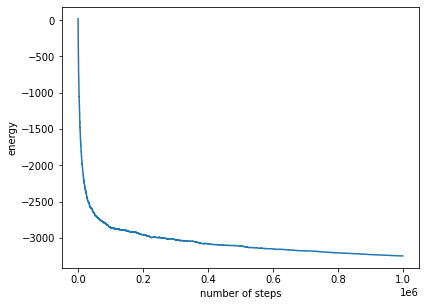

In [41]:
plotEnergy(steps,currentEnergyList)

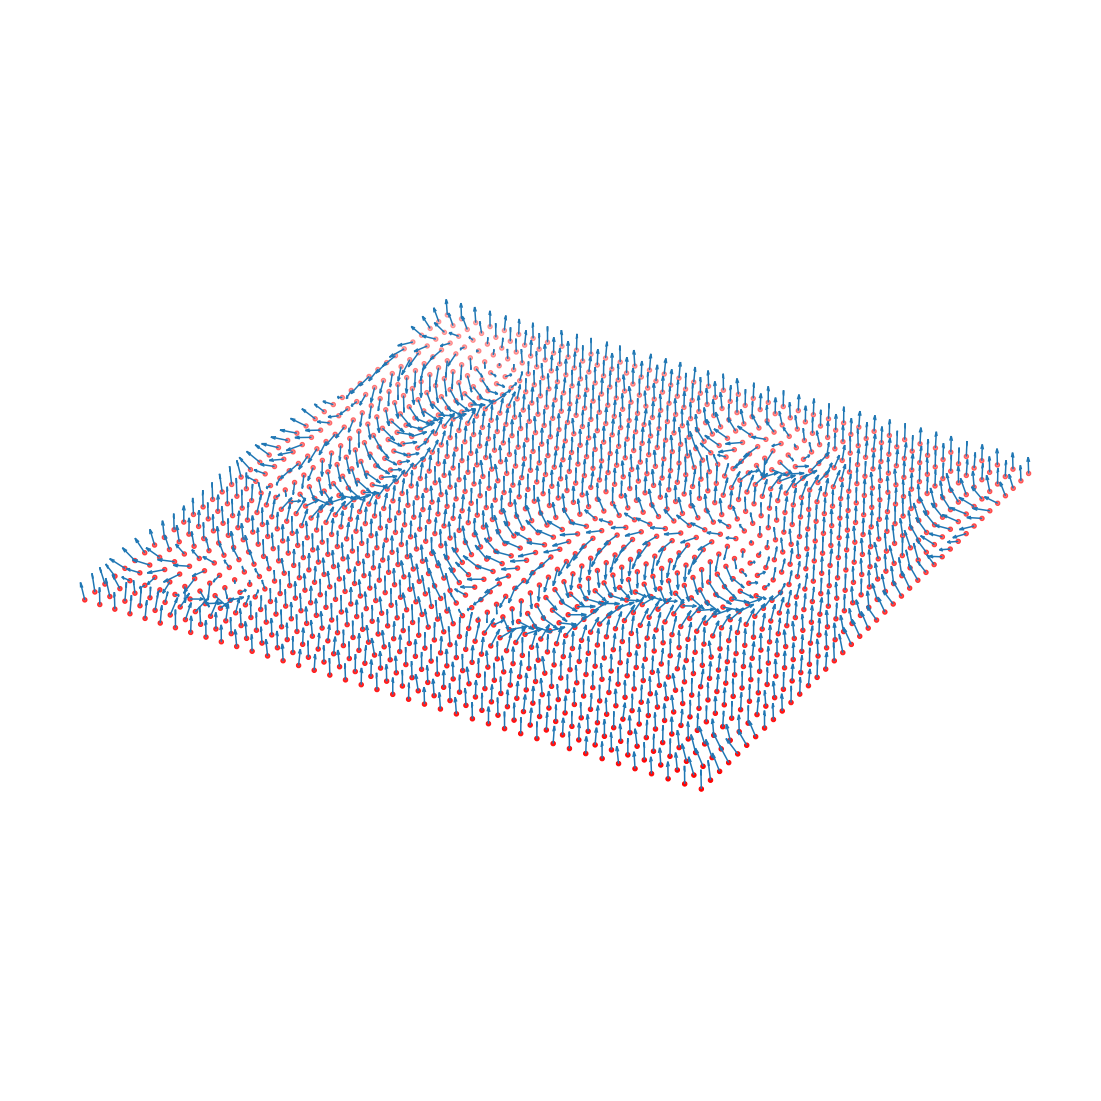

In [40]:
plotMagnet(magnet4)

#the system looks pretty much ordered, however we see that some places are disordered in the sample
#And this is what happens when you make the system larger than it gets more and more difficult
#to really converge to the actual energetic minimum.
